# Visual Explanations for CNN Decisions

Convolutional Neural Networks have made a lot of progress in Computer Vision. Their accuracy is as good as humans in some tasks. However it remains hard to explain the predictions of convolutional neural networks.

It is often helpful to be able to explain why a model made the prediction it made. For example if a model predicts the following image is a car mirror, it is hard to say why without visualizing the predicted class.

ToDo: Original image | volcano class visualization | car mirror class visualization |

Visualizations also help build confidence about the predictions of a model. For example, even if a model correctly predicts birds as birds, we would want to confirm that the model bases its decision on the features of bird and not on the features of some other object that might occur together with birds in the dataset (like leaves).

In this tutorial, we show how to visualize the predictions made by convolutional neural networks using Gradient-weighted Class Activation Mapping. Unlike many other visualization methods, Grad-CAM can be used on a wide variety of CNN model families - CNNs with fully connected layers, CNNs used for structural outputs (e.g. captioning), CNNs used in tasks with multi-model input (e.g. VQA) or reinforcement learning without architectural changes or re-training.

In the rest of this notebook, we will explain how to visualize predictions made by AlexNet. We begin by importing the required dependencies.

In [1]:
import mxnet as mx
from mxnet import gluon

from matplotlib import pyplot as plt
import numpy as np
import cv2

from cnnviz.layers import Activation, Conv2D
from cnnviz import cnnviz

Notice that we import `ReLU` and `Conv2D` from `cnnviz` (included in this folder) instead of `mxnet.gluon.nn`. 
- We use a modified `ReLU` because we use guided backpropagation for visualization and guided backprop requires `ReLU` layer to block the backward flow of negative gradients corresponding to the neurons which decrease the activation of the higher layer unit we aim to visualize.
- We use a modified `Conv2D` (a wrapper on top of Gluon’s `Conv2D`) because we want to capture the output of a given convolutional layer and its gradients. This is needed to implement Grad-CAM.

## Building the network to visualize
Next, we build the network we want to visualize. This code was taken from [model zoo](https://github.com/apache/incubator-mxnet/blob/master/python/mxnet/gluon/model_zoo/vision/alexnet.py) and refactored to make it easy to switch between cnnviz’s and Gluon’s implementation of ReLU and Conv2D.

In [2]:
import os
from mxnet.gluon.model_zoo import model_store

from mxnet.gluon.nn import MaxPool2D, Flatten, Dense, Dropout
from cnnviz.layers import Activation, Conv2D

class AlexNet(mx.gluon.HybridBlock):
    def __init__(self, classes=1000, **kwargs):
        super(AlexNet, self).__init__(**kwargs)
        with self.name_scope():
            self.features = gluon.nn.HybridSequential(prefix='')
            with self.features.name_scope():
                self.features.add(Conv2D(64, kernel_size=11, strides=4, padding=2))
                self.features.add(Activation('relu'))
                self.features.add(MaxPool2D(pool_size=3, strides=2))

                self.features.add(Conv2D(192, kernel_size=5, padding=2))
                self.features.add(Activation('relu'))
                self.features.add(MaxPool2D(pool_size=3, strides=2))

                self.features.add(Conv2D(384, kernel_size=3, padding=1))
                self.features.add(Activation('relu'))

                self.features.add(Conv2D(256, kernel_size=3, padding=1))
                self.features.add(Activation('relu'))

                self.features.add(Conv2D(256, kernel_size=3, padding=1))
                self.features.add(Activation('relu'))
                self.features.add(MaxPool2D(pool_size=3, strides=2))

                self.features.add(Flatten())

                self.features.add(Dense(4096))
                self.features.add(Activation('relu'))
                self.features.add(Dropout(0.5))

                self.features.add(Dense(4096))
                self.features.add(Activation('relu'))
                self.features.add(Dropout(0.5))

            self.output = Dense(classes)

    def hybrid_forward(self, F, x):
        x = self.features(x)
        x = self.output(x)
        return x

## Loading pretrained weights
We’ll use pre-trained weights (trained on ImageNet) from model zoo instead of training the model from scratch.

In [3]:
def build_alexnet(pretrained=False, ctx=mx.cpu(),
            root=os.path.join('~', '.mxnet', 'models'), **kwargs):
    net = AlexNet(**kwargs)
    if pretrained:
        net.load_params(model_store.get_model_file('alexnet', root=root), ctx=ctx)
    return net

Alexnet works on 224x224 images. So, we’ll resize the image to 224x224 before feeding it to the network. We normalize the images using the same parameters ImageNet dataset was normalised using to create the pretrained model. These parameters are published here. We use transpose to convert the image to channel-last format.

## Preprocessing and other helpers

In [4]:
image_sz = (224, 224)

def preprocess(data):
    data = mx.image.imresize(data, image_sz[0], image_sz[1])
    data = data.astype(np.float32)
    data = data/255
    data = mx.image.color_normalize(data,
                                    mean=mx.nd.array([0.485, 0.456, 0.406]),
                                    std=mx.nd.array([0.229, 0.224, 0.225]))
    data = mx.nd.transpose(data, (2,0,1))
    return data

alexnet = build_alexnet(pretrained=True)

We define some helper functions:

In [5]:
def read_image_mxnet(path):
    with open(path, 'rb') as fp:
        img_bytes = fp.read()
    return mx.img.imdecode(img_bytes)

def read_image_cv(path):
    return cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB), image_sz)

def show_images(images):
    titles = ['Original', 'Grad-CAM', 'Guided Grad-CAM', 'Saliency']
    num_images = len(images)
    fig=plt.figure(figsize=(15,15))
    rows, cols = 1, num_images
    for i in range(num_images):
        fig.add_subplot(rows, cols, i+1)
        plt.xlabel(titles[i])
        plt.imshow(images[i], cmap='gray' if i==3 else None)
    plt.show()

In [6]:
def visualize(net, img_path, conv_layer_name):
    image = read_image_mxnet(img_path)
    image = preprocess(image)
    image = image.expand_dims(axis=0)    
    orig_img = read_image_cv(img_path)
    vizs = cnnviz.visualize_class_activation(net, image, orig_img, conv_layer_name)
    return (orig_img, *vizs)

Next, we need to get the name of the topmost convolutional layer that extracts features from the image. In our network, feature extractors are added to a HybridSequential block named `features`. You can list the layers in that block by just printing `alexnet.features`. You can see that the topmost convolutional layer is in index 10. `alexnet.features[10]._name` will give the name of the layer.

In [7]:
last_conv_layer_name = alexnet.features[10]._name
print(last_conv_layer_name)

alexnet0_conv2d4


In [8]:
with open("img/fish.jpg", 'rb') as fp:
    str_image = fp.read()

image = mx.img.imdecode(str_image)
image = preprocess(image)
image = image.expand_dims(axis=0)

out = alexnet(image)
out.argmax(axis=1)


[0.]
<NDArray 1 @cpu(0)>

We now have everything we need to start visualizing. Let’s visualize 

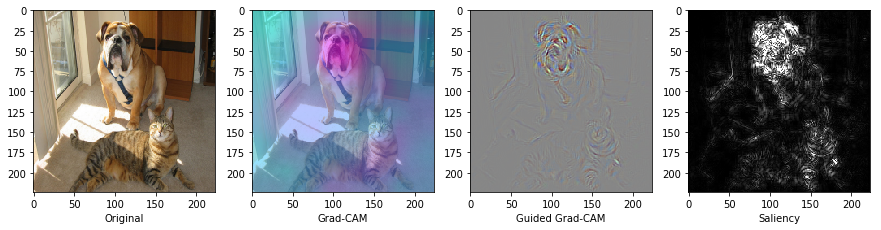

In [9]:
show_images(visualize(alexnet, "img/cat_dog.png", last_conv_layer_name))

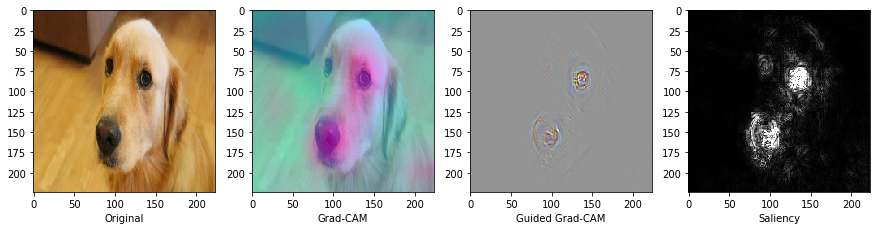

In [10]:
show_images(visualize(alexnet, "img/dog2.jpg", last_conv_layer_name))

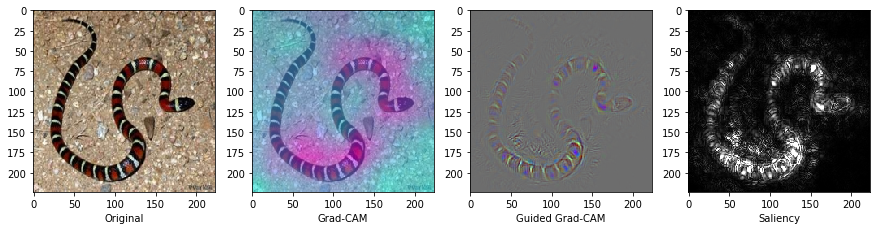

In [11]:
show_images(visualize(alexnet, "img/snake.jpg", last_conv_layer_name))

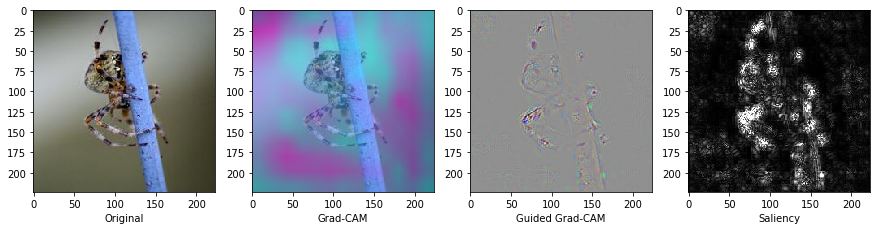

In [12]:
show_images(visualize(alexnet, "img/spider.png", last_conv_layer_name))

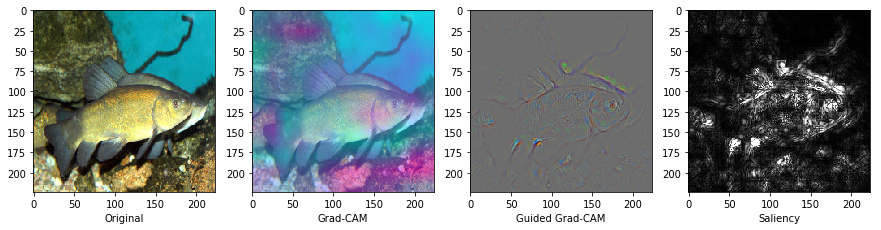

In [13]:
show_images(visualize(alexnet, "img/fish.jpg", last_conv_layer_name))